# Multi-qubit: All-to-all Ising example

In [6]:
import itertools

import equinox as eqx
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from rich.pretty import pprint

from squint.circuit import Circuit
from squint.ops.base import SharedGate
from squint.ops.dv import DiscreteVariableState, HGate, Phase, RXXGate
from squint.utils import partition_op

In [7]:
n = 4
circuit = Circuit()
for i in range(n):
    circuit.add(DiscreteVariableState(wires=(i,), n=(0,)))

for i, j in itertools.combinations(list(range(n)), 2):
    circuit.add(RXXGate(wires=(i, j), theta=1.0))

circuit.add(
    SharedGate(op=Phase(wires=(0,), phi=0.1 * jnp.pi), wires=tuple(range(1, n))),
    "phase",
)

for i in range(n):
    circuit.add(HGate(wires=(i,)))

params, static = partition_op(circuit, "phase")
pprint(params)

Circuit(
  ops={
│   0:
│   DiscreteState(wires=(None,), n=[(None, (None,))]),
│   1:
│   DiscreteState(wires=(None,), n=[(None, (None,))]),
│   2:
│   DiscreteState(wires=(None,), n=[(None, (None,))]),
│   3:
│   DiscreteState(wires=(None,), n=[(None, (None,))]),
│   4:
│   RXXGate(wires=(None, None), theta=None),
│   5:
│   RXXGate(wires=(None, None), theta=None),
│   6:
│   RXXGate(wires=(None, None), theta=None),
│   7:
│   RXXGate(wires=(None, None), theta=None),
│   8:
│   RXXGate(wires=(None, None), theta=None),
│   9:
│   RXXGate(wires=(None, None), theta=None),
│   'phase':
│   SharedGate(
│     wires=(None, None, None, None),
│     op=Phase(wires=(None,), phi=weak_f32[]),
│     copies=[
│   │   Phase(wires=(None,), phi=None),
│   │   Phase(wires=(None,), phi=None),
│   │   Phase(wires=(None,), phi=None)
│     ],
│     where=None,
│     get=None
│   ),
│   11:
│   HGate(wires=(None,)),
│   12:
│   HGate(wires=(None,)),
│   13:
│   HGate(wires=(None,)),
│   14:
│   HGate(wires=(None,))
  }
)

2025-03-05 23:43:59.404 | INFO     | squint.circuit:compile:114 -   Complete contraction:  a,b,c,d,aebf,egch,gidj,fkhl,kmjn,lonp,iq,mr,os,pt,qu,rv,sw,tx->uvwx
         Naive scaling:  24
     Optimized scaling:  6
      Naive FLOP count:  3.020e+8
  Optimized FLOP count:  9.440e+2
   Theoretical speedup:  3.199e+5
  Largest intermediate:  1.600e+1 elements
--------------------------------------------------------------------------------
scaling        BLAS                current                             remaining
--------------------------------------------------------------------------------
   4           GEMM            aebf,a->ebf    b,c,d,egch,gidj,fkhl,kmjn,lonp,iq,mr,os,pt,qu,rv,sw,tx,ebf->uvwx
   4    GEMV/EINSUM            egch,c->egh    b,d,gidj,fkhl,kmjn,lonp,iq,mr,os,pt,qu,rv,sw,tx,ebf,egh->uvwx
   4    GEMV/EINSUM            gidj,d->gij    b,fkhl,kmjn,lonp,iq,mr,os,pt,qu,rv,sw,tx,ebf,egh,gij->uvwx
   3    GEMV/EINSUM              ebf,b->ef    fkhl,kmjn,lonp,iq,mr,os,pt,q

[Text(0.5, 0, 'Phase, $\\varphi$'), Text(0, 0.5, '$\\mathcal{I}_\\varphi^C$')]

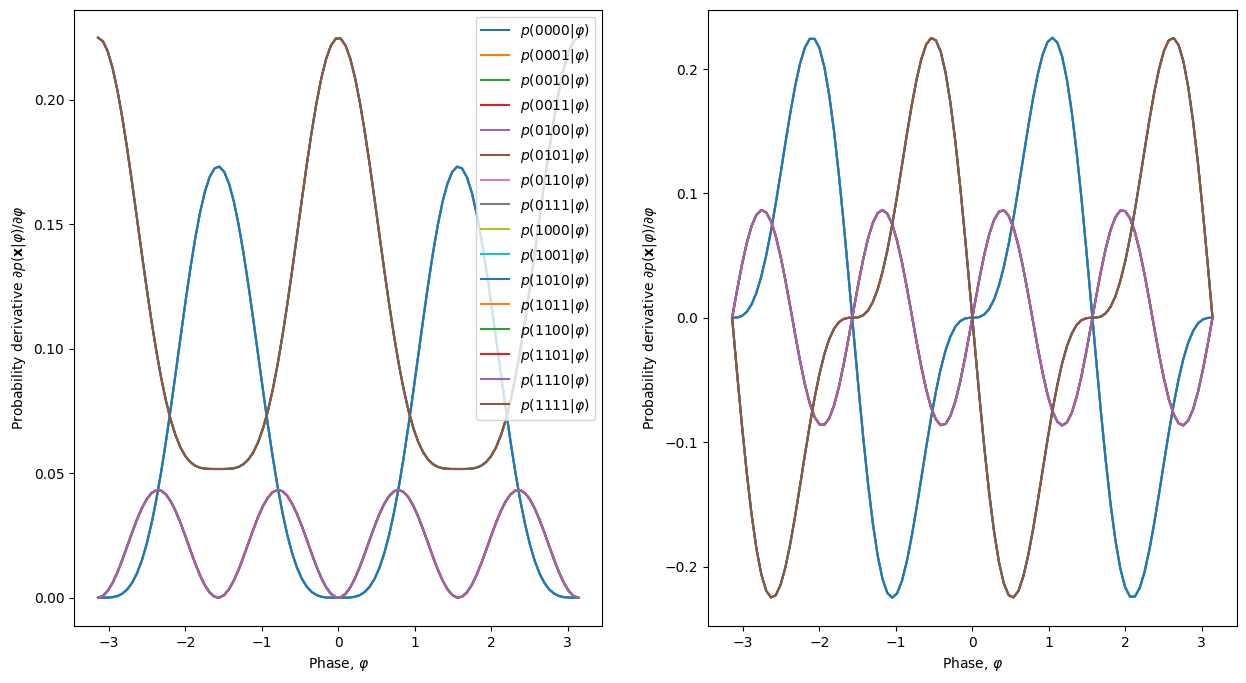

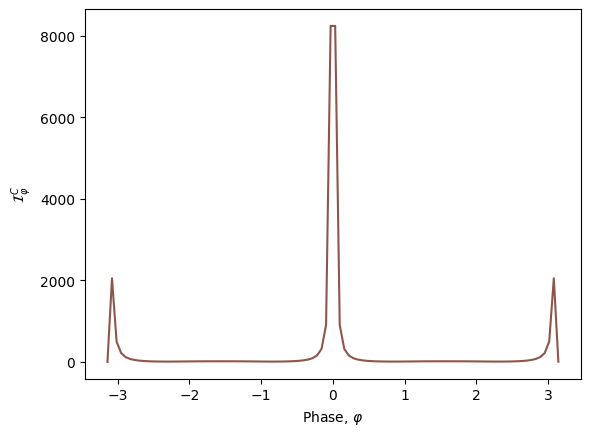

In [8]:
sim = circuit.compile(params, static, dim=2, optimize="greedy")

get = lambda pytree: jnp.array([pytree.ops["phase"].op.phi])

phis = jnp.linspace(-jnp.pi, jnp.pi, 100)
params = eqx.tree_at(
    lambda pytree: pytree.ops["phase"].op.phi, params, jnp.expand_dims(phis, axis=1)
)

probs = eqx.filter_vmap(sim.probabilities.forward)(params)
grads = get(eqx.filter_vmap(sim.probabilities.grad)(params)).squeeze()
cfims = eqx.filter_vmap(sim.probabilities.cfim, in_axes=(None, 0))(get, params)

colors = sns.color_palette(n_colors=jnp.prod(jnp.array(probs.shape[1:])))
fig, axs = plt.subplots(ncols=2, figsize=[15, 8])
for i, idx in enumerate(
    itertools.product(*[list(range(ell)) for ell in probs.shape[1:]])
):
    axs[0].plot(
        phis,
        probs[:, *idx],
        label=f"$p({''.join(map(str, idx))}" + r"|\varphi)$",
        color=colors[i],
    )
    axs[1].plot(
        phis,
        grads[:, *idx],
        label=r"$\partial"
        + f"p({''.join(map(str, idx))}"
        + r"|\varphi) / \partial \varphi$",
        color=colors[i],
    )

axs[0].legend()
for ax in axs:
    ax.set(
        xlabel=r"Phase, $\varphi$",
        ylabel=r"Probability derivative $\partial p(\mathbf{x} | \varphi) / \partial \varphi$",
    )


fig, ax = plt.subplots()
ax.plot(phis, cfims.squeeze(), color=colors[i])
ax.set(xlabel=r"Phase, $\varphi$", ylabel=r"$\mathcal{I}_\varphi^C$")